In [2]:
import numpy as np
from tqdm import tqdm

def expected_score(r_player, r_opponent):
    """ Calculate the expected score for the player. """
    return 1 / (1 + 10 ** ((r_opponent - r_player) / 400))

def update_rating(r_player, r_opponent, actual_score, K=20):
    """ Update the player's rating after a game. """
    E = expected_score(r_player, r_opponent)
    return r_player + K * (actual_score - E)

def simulate_elo_games(true_skill_rating, initial_rating=1500, K=20, max_diff=100, target_rating=2000):
    """ Simulate games until the player reaches their target rating. """
    current_rating = initial_rating

    results = []
    
    while not target_rating - 10 <= current_rating <= target_rating + 10:
        # Opponent's rating is within max_diff of the player's rating
        opponent_rating = np.random.randint(current_rating - max_diff/2, current_rating + max_diff/2 + 1)
        
        # Calculate the expected winrate for a 1900 player against this opponent
        expected_winrate = expected_score(true_skill_rating, opponent_rating)

        # Simulate the game result (1 for win, 0 for loss)
        game_result = np.random.binomial(1, expected_winrate)
        
        # Update the player's rating
        current_rating = update_rating(current_rating, opponent_rating, game_result, K)
        
        results.append(current_rating)

    return results, len(results)

# Simulate the games
smallest_rating, biggest_rating = 1200, 2300
initial_rating = 1500
num_simulations = 10000

# Initialize an empty list for the results
final_results_elo = []

# Run the simulations
for true_skill_rating in np.linspace(smallest_rating, biggest_rating, 50):
    results = []
    for _ in tqdm(range(num_simulations)):
        elo_games, elo_games_needed = simulate_elo_games(true_skill_rating, initial_rating, target_rating=true_skill_rating)
        results.append(elo_games_needed)
        
    # Convert the list to a NumPy array
    results_array = np.array(results)
    log_results = np.log(results_array)
    # Calculate the average
    average_games = np.exp(np.mean(log_results))
    final_results_elo.append((true_skill_rating, average_games))
    
final_results_elo

100%|██████████| 10000/10000 [00:00<00:00, 2099986.98it/s]
C:\Users\g_bruno\AppData\Local\Temp\ipykernel_22384\2679767514.py:53: RuntimeWarning: divide by zero encountered in log
  log_results = np.log(results_array)
100%|██████████| 10000/10000 [00:06<00:00, 1553.39it/s]


[(1200.0, 84.50258603071335),
 (1222.4489795918366, 80.59094862309068),
 (1244.8979591836735, 77.10665050493066),
 (1267.3469387755101, 73.66410471755593),
 (1289.795918367347, 69.37214610863938),
 (1312.2448979591836, 65.42199708878326),
 (1334.6938775510205, 60.389296945458575),
 (1357.142857142857, 54.7547497679318),
 (1379.591836734694, 48.12683344766598),
 (1402.0408163265306, 41.03166403123706),
 (1424.4897959183672, 32.67344017159733),
 (1446.938775510204, 23.280629675028656),
 (1469.387755102041, 10.984449577807727),
 (1491.8367346938776, 0.0),
 (1514.2857142857142, 2.934263692695184),
 (1536.734693877551, 13.25862509617617),
 (1559.1836734693877, 24.96002431698981),
 (1581.6326530612246, 35.00765375493975),
 (1604.0816326530612, 43.117441466182946),
 (1626.5306122448978, 49.80512395228152),
 (1648.9795918367347, 56.266229230943175),
 (1671.4285714285716, 61.31926811500251),
 (1693.8775510204082, 66.09708441558517),
 (1716.3265306122448, 70.75648872763581),
 (1738.7755102040817

In [3]:
import glicko2
import numpy as np
from tqdm import tqdm

def simulate_glicko2_games(true_skill_rating, init_player_rating=1500, init_player_rd=100, max_diff=100, target_rating=2000):
    """Simulate Glicko-2 games for a player until a number of games are played."""
    results = []

    real_skill_player = glicko2.Player(rating=true_skill_rating, rd=50)
    init_player = glicko2.Player(rating=init_player_rating, rd=init_player_rd)
    
    while not target_rating -10 <= init_player.getRating() <= target_rating +10:
        opp_rating = np.random.randint(init_player.getRating() - max_diff/2, init_player.getRating() + max_diff/2 + 1)
        opponent_rd = 50
        
        # Calculate expected winrate for the true skill against this opponent
        expected_winrate = real_skill_player._E((opp_rating - 1500) / 173.7178, opponent_rd / 173.7178)
        
        
        # Simulate the game result (1 for win, 0 for loss) based on true skill
        game_result = 1 if np.random.random() < expected_winrate else 0
        
        #   print(f"Player: {init_player.getRating()}       RD: {init_player.getRd()}           Opp: {opp_rating}           Expected WR: {expected_winrate}")
        
        # Update the player's rating
        init_player.update_player([opp_rating], [opponent_rd], [game_result])
        results.append(init_player.getRating())

    return results, len(results)

# Simulate the games
smallest_rating, biggest_rating = 1200, 2300
num_simulations = 10000
initial_rating = 1500
initial_rd = 150  # Starting RD

# Initialize an empty list for the results
final_results_glicko = []

# Run the simulations
for true_skill_rating in np.linspace(smallest_rating, biggest_rating, 50):
    results = []
    for _ in tqdm(range(num_simulations)):
        glicko_games, glicko_games_needed = simulate_glicko2_games(true_skill_rating,
                                                                   init_player_rating = initial_rating,
                                                                   init_player_rd = initial_rd,
                                                                   target_rating=true_skill_rating)
        results.append(glicko_games_needed)
        
    # Convert the list to a NumPy array
    results_array = np.array(results)
    log_results = np.log(results_array)
    # Calculate the average
    average_games = np.exp(np.mean(log_results))
    final_results_glicko.append((true_skill_rating, average_games))
    
final_results_glicko

100%|██████████| 10000/10000 [00:00<00:00, 489971.61it/s]
C:\Users\g_bruno\AppData\Local\Temp\ipykernel_22384\2613629099.py:52: RuntimeWarning: divide by zero encountered in log
  log_results = np.log(results_array)
100%|██████████| 10000/10000 [00:21<00:00, 463.45it/s]


[(1200.0, 35.353254881649086),
 (1222.4489795918366, 32.34552210981855),
 (1244.8979591836735, 28.80090548350538),
 (1267.3469387755101, 27.141160689696274),
 (1289.795918367347, 23.909477394459998),
 (1312.2448979591836, 20.814664048987925),
 (1334.6938775510205, 20.333552069057788),
 (1357.142857142857, 14.43253769011314),
 (1379.591836734694, 16.64644770853015),
 (1402.0408163265306, 9.295359844292372),
 (1424.4897959183672, 14.340432617015566),
 (1446.938775510204, 3.2809042590300863),
 (1469.387755102041, 12.190539344156658),
 (1491.8367346938776, 0.0),
 (1514.2857142857142, 9.668598427365689),
 (1536.734693877551, 11.468537019159086),
 (1559.1836734693877, 4.30275055490075),
 (1581.6326530612246, 14.172364938103037),
 (1604.0816326530612, 9.212987096891654),
 (1626.5306122448978, 16.970340824854308),
 (1648.9795918367347, 15.54236700373895),
 (1671.4285714285716, 19.684257501095434),
 (1693.8775510204082, 22.382901061160556),
 (1716.3265306122448, 23.982482596104326),
 (1738.7755

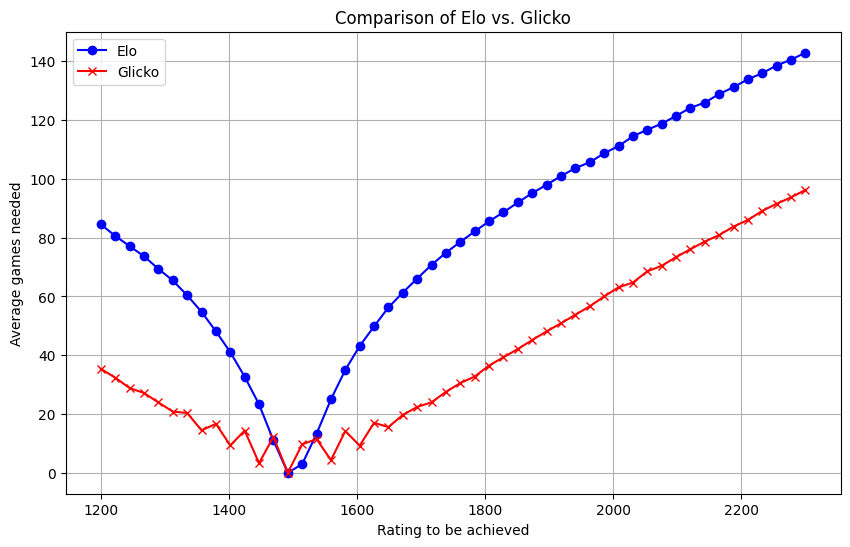

In [4]:
import matplotlib.pyplot as plt

rating = [sim[0] for sim in final_results_elo]
elo_values = [sim[1] for sim in final_results_elo]
glicko_values = [sim[1] for sim in final_results_glicko]

plt.figure(figsize=(10, 6))
plt.plot(rating, elo_values, marker='o', color='blue', label='Elo')
plt.plot(rating, glicko_values, marker='x', color='red', label='Glicko')
plt.title("Comparison of Elo vs. Glicko")
plt.xlabel("Rating to be achieved")
plt.ylabel("Average games needed")
plt.grid(True)
plt.legend()
plt.show()

In [1]:
# Save the figure
plt.savefig("elo_vs_glicko_comparison.png", dpi=300, bbox_inches='tight')


NameError: name 'plt' is not defined

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# Assuming 'df' is your DataFrame
# df = pd.read_csv('your_data.csv')  # Load your DataFrame here

def get_color(win_loss):
    return 'red' if win_loss == 0 else 'blue'

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot each point in the DataFrame
for i in range(len(df)):
    ax.scatter(df['match_no'][i], df['rating'][i], df['deviation'][i], 
               color=get_color(df['win_loss'][i]))

ax.set_xlabel('Match Number')
ax.set_ylabel('Rating')
ax.set_zlabel('Deviation')

plt.show()
